# Pozo August Weekly Plots

__Author:__ Pat McCornack

__Date:__ 10/31/24

__Purpose:__ For each week in August, create line plots with air temp, RH, fog drip, and dew point in order to consider the relationships between the variables. 


In [94]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Functions
----

In [95]:
# Check dew point
def calc_dew_point(temp_series, rh_series):
    b = 17.625
    c = 243.04

    dew_point = []
    for i in range(len(temp_series)):
        gamma = np.log((rh_series.iloc[i]/100)) + (b*temp_series.iloc[i])/(c+temp_series.iloc[i])
        dp = (c * gamma) / (b - gamma)

        dew_point.append(dp)

    return dew_point

# Calculate dew point depression
def calc_dpd(airtemp_series, dewpoint_series):
    dpd = airtemp_series - dewpoint_series

    return dpd 

def fog_rule_filter(data_df, stats_df, var_list, inverse=False, stat_bounds=('min', 'max')):
    df = data_df.copy()
    for var in var_list:
        df = df.loc[df[var].between(stats_df[var][stat_bounds[0]], stats_df[var][stat_bounds[1]])]

    if inverse:
        df_concat = pd.concat([data_df, df]).drop_duplicates(keep=False)
        return df_concat
    else:
        return df

def assess_accuracy(df, inverse=False, title=None):
    print('Total Count')
    count_df = pd.DataFrame(df['condition'].value_counts())
    no_fog_perc = count_df.loc['no fog']['count'] / 67132 * 100
    if count_df.shape[0] == 2:
        fog_perc = count_df.loc['fog']['count'] / 6962 * 100
        count_df['percent'] = [no_fog_perc, fog_perc]
    else:
        count_df['percent'] = no_fog_perc
    display(count_df)


    month_gp = df.groupby('month')['condition'].value_counts().reset_index()
    month_piv = month_gp.pivot_table(month_gp, index='month', columns='condition')
    month_piv.plot(kind='bar', ylabel='count', rot=0, title=title)
    if inverse: 
        plt.legend(["False Negative", "True Negative"], loc="upper left")
    else: 
        plt.legend(["True Positive", "False Positive"], loc="upper left")
    plt.show()


# Main
----

In [96]:
df_fpath = '/Users/patmccornack/Documents/ucsb_fog_project/data/csv/pozo_fog_aug22.csv'
df = pd.read_csv(df_fpath)
#df.columns

In [97]:
#### Load and Pre-process Data #####

# Read in data
df_fpath = '/Users/patmccornack/Documents/ucsb_fog_project/data/csv/pozo_fog_aug22.csv'
df = pd.read_csv(df_fpath)

# Subset to select variables 
col_subset = ['time', 'fog-harp-ml', 'fog-remove-flag', 'relative-humidity-minimum-rh-min-pct',
       'air-temperature-minimum-degc', 'barometric-pressure-average-bp-mbar-avg-mb',
       'leaf-wetness-average-l-wm-v-avg-mv',
       'rainfall-sum-rain-mm-tot-mm',
       'barometric-pressure-average-vp-mbar-avg-mb',
       'wind-speed-wind-vector-cells-ws-ms-u-wvt-ms',
        'air-temperature-wind-vector-cells-wind-dir-sdu-wvt-deg']

col_names = ['time', 'fog', 'fog_flag', 'RH_min', 'air_temp_min', 'atm_pressure',
             'leaf_wetness', 'rainfall', 'vapor_pressure', 'wind_speed_avg',
              'wind_dir']
df = df[col_subset]
df.columns = col_names
df.head()

# Create variables
df['dew_point'] = calc_dew_point(df['air_temp_min'], df['RH_min'])
df['dew_point_depression'] = calc_dpd(df['air_temp_min'], df['dew_point'])

# Drop fog_flag variable - not needed here
df.drop('fog_flag', axis=1, inplace=True)

# Label fog observations
df['condition'] = df['fog'].apply(lambda x: 'fog' if x != 0 else 'no fog')

# Set Index to time
df['time'] = pd.to_datetime(df['time'], format='%m/%d/%y %H:%M')
df.set_index('time', inplace=True, drop=False)

df.head()

,time,fog,RH_min,air_temp_min,atm_pressure,leaf_wetness,rainfall,vapor_pressure,wind_speed_avg,wind_dir,dew_point,dew_point_depression,condition
time,,,,,,,,,,,,,
2022-08-01 00:00:00,2022-08-01 00:00:00,0.00,95.40,15.80,989.24,306.00,0.00,17.51,2.15,9.88,15.07,0.73,no fog
2022-08-01 00:10:00,2022-08-01 00:10:00,0.00,96.30,15.80,989.43,302.80,0.00,17.58,2.08,11.84,15.21,0.59,no fog
2022-08-01 00:20:00,2022-08-01 00:20:00,0.00,96.10,16.00,989.42,295.60,0.00,17.75,1.83,13.02,15.38,0.62,no fog
2022-08-01 00:30:00,2022-08-01 00:30:00,0.00,96.90,16.20,989.38,291.80,0.00,18.00,1.35,21.67,15.71,0.49,no fog
2022-08-01 00:40:00,2022-08-01 00:40:00,0.00,97.50,16.30,989.31,289.10,0.00,18.19,1.08,25.53,15.90,0.40,no fog


In [98]:
df.tail(1)

,time,fog,RH_min,air_temp_min,atm_pressure,leaf_wetness,rainfall,vapor_pressure,wind_speed_avg,wind_dir,dew_point,dew_point_depression,condition
time,,,,,,,,,,,,,
2022-08-31 23:50:00,2022-08-31 23:50:00,0.00,93.50,14.20,982.10,277.10,0.00,15.50,4.20,16.93,13.17,1.03,no fog


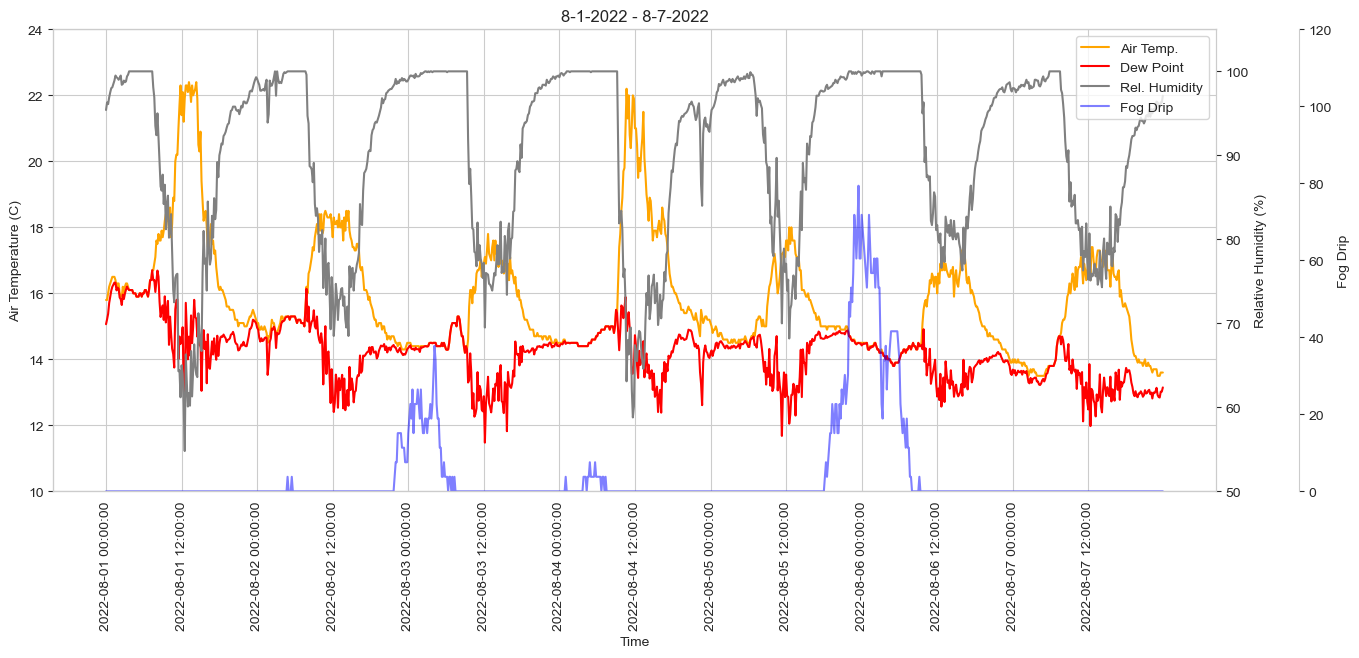

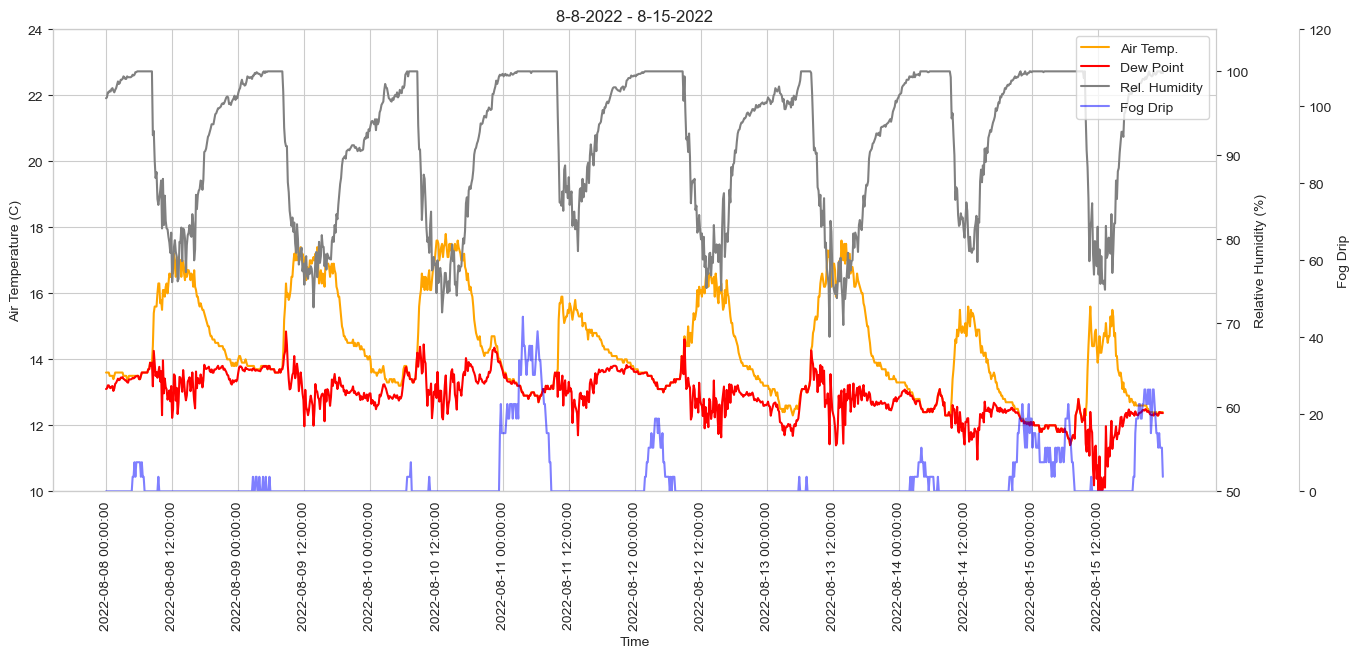

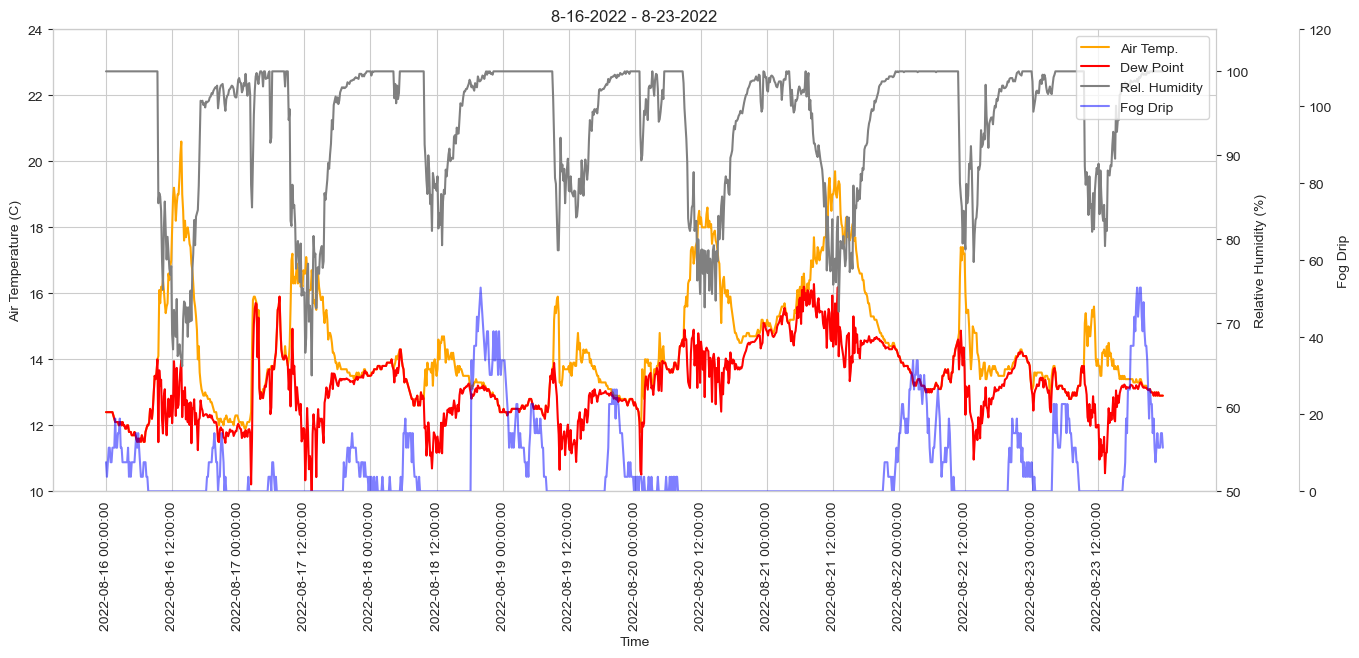

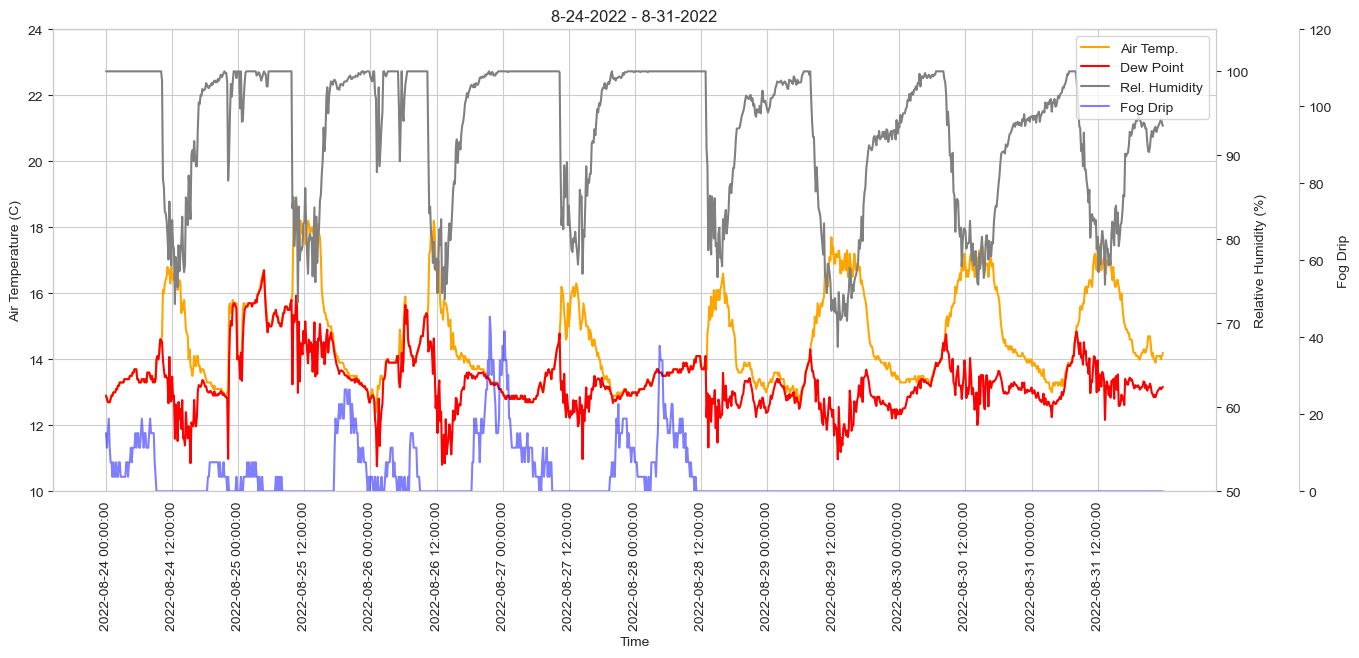

In [119]:
#### Make Plots ####

weeks = [['8-1-2022  00:00:00', '8-7-2022  23:50:00'], 
         ['8-8-2022  00:00:00', '8-15-2022  23:50:00'],
         ['8-16-2022  00:00:00', '8-23-2022  23:50:00'],
         ['8-24-2022  00:00:00', '8-31-2022  23:50:00']]


def plot_week(df, title):
    # Set x axis
    xticks = df.index[::6*12]

    fig, ax = plt.subplots(figsize=(15,6))
    
    # Plot Air Temperature
    sns.lineplot(data=df['air_temp_min'],
            color='orange',
            label='Air Temp.',
            legend=False,
            ax=ax)
    ax.set_ylim(10,24)
    ax.set(ylabel='Air Temperature (C)',
           xlabel='Time')
    
    plt.xticks(ticks=xticks, labels=xticks, rotation=90)
    
    # Plot Air Temp
    ax2 = ax.twinx()
    ax2.grid(False)

    # Plot Relative Humidity
    sns.lineplot(data=df['RH_min'],
                color='gray',
                label='Rel. Humidity',
                legend=False,
                ax=ax2)
    ax2.set_ylim(50,105)
    ax2.grid(False)
    ax2.set(ylabel='Relative Humidity (%)')

    # Plot Fog
    ax3 = ax.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis to the right
    ax3.set_ylim(0,120)
    sns.lineplot(data=df['fog'],
                 color='blue',
                 label='Fog Drip',
                 alpha=0.5,
                 legend=False,
                 ax=ax3)
    ax3.grid(False)
    ax3.set(ylabel='Fog Drip')

    # Plot Relative Humidity
    sns.lineplot(data=df['dew_point'],
                color='red',
                label='Dew Point',
                legend=False,
                ax=ax)

    # Gather handles and labels for all three axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()

    # Combine them and add the legend
    ax3.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper right')

    plt.title(title)

    plt.show()

for week in weeks:
    plot_week(df=df[week[0] : week[1]],
              title=f"{week[0].split(' ')[0]} - {week[1].split(' ')[0]}")
